# [IAPR][iapr]: Lab 2 ‒  Object description

**Group ID:** xx

**Author 1 (sciper):** Student Name 1 (xxxxx)  
**Author 2 (sciper):** Student Name 2 (xxxxx)   
**Author 3 (sciper):** Student Name 3 (xxxxx)   

**Release date:** 25.03.2022  
**Due date:** 08.04.2022 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.


[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [3]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
data_part1 = os.path.join(data_base_path, data_folder, 'part1')
data_part2 = os.path.join(data_base_path, data_folder, 'part2')

tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try:
1. Fourier Descriptors (15pts). 
    1. Implementation (10 pts).
    2. Showing invariance to rotation, translation and scaling (5 pts).
2. Additional method of your choice (5 pts)


**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point. Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

### 1.1 Data visualization

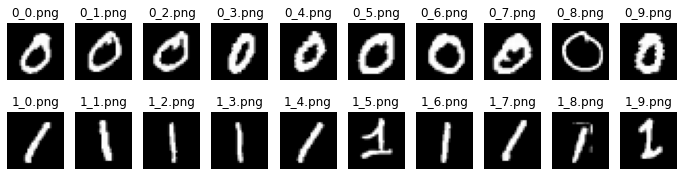

In [4]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

def load(path, digit='0'):
    digit_path = os.path.join(path, digit)
    digit_names = [nm for nm in os.listdir(digit_path) if '.png' in nm]  # make sure to only load .png
    digit_names.sort()  # sort file names
    ic = skimage.io.imread_collection([os.path.join(digit_path, nm) for nm in digit_names])
    digit_im = skimage.io.concatenate_images(ic)
    return digit_im, digit_names
                        
#  Load zeros and ones
zeros_im, zeros_names = load(data_part1, digit='0')
ones_im, ones_names = load(data_part1, digit='1')

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

In [5]:
import cv2 as cv
import numpy as np
from skimage import measure
from skimage.morphology import opening

In [6]:
contours = measure.find_contours(im, 0.8)

### 1.2 Fourier descriptors (15 pts)

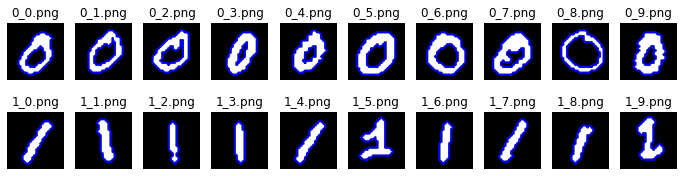

In [7]:
# Add your implementation and discussion
zeros_preproc = []
ones_preproc = []

fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    
    ret,im = cv.threshold(im,100,255,cv.THRESH_BINARY)
    contours = measure.find_contours(im, 0.5)
    zeros_preproc.append(im)
    ax.imshow(im, cmap='gray')
    ax.plot(contours[0][:, 1], contours[0][:, 0], linewidth=2, c='blue')
    ax.plot(contours[1][:, 1], contours[1][:, 0], linewidth=2, c='blue')
    ax.axis('off')
    ax.set_title(nm)

for ax, im, nm in zip(axes[1], ones_im, ones_names):

    im = opening(im)
    ret,im = cv.threshold(im,20,255,cv.THRESH_BINARY)
    contours = measure.find_contours(im, 0.5)
    ones_preproc.append(im)
    ax.imshow(im, cmap='gray')
    ax.plot(contours[0][:, 1], contours[0][:, 0], linewidth=2, c='blue')
    ax.axis('off')
    ax.set_title(nm)

In [8]:
def fourier_descriptor(contour):
    u_k = contour[:, 1] + 1j * (contour[:, 0])
    u_k_fft = np.abs(np.fft.fft(u_k))
    norm = np.linalg.norm(u_k_fft)
    return u_k_fft[1]/norm, u_k_fft[2]/norm

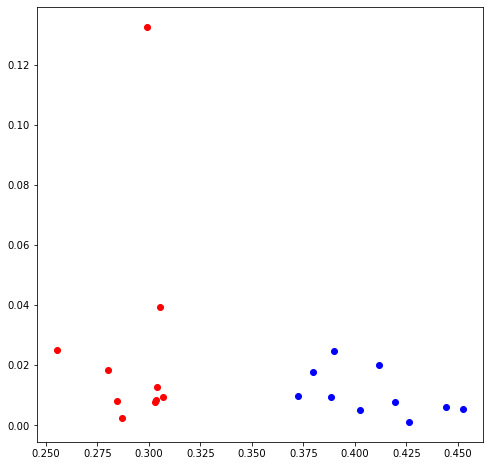

In [10]:
fig = plt.figure(figsize=(8, 8))
for zero in zeros_preproc:
    fft_1, fft_2 = fourier_descriptor(measure.find_contours(zero, 0.5)[0])
    plt.scatter(fft_1, fft_2, c='blue')

for one in ones_preproc:
    fft_1, fft_2 = fourier_descriptor(measure.find_contours(one, 0.5)[0])
    # plt.scatter(fft_1, fft_1/fft_2, c='red')
    plt.scatter(fft_1, fft_2, c='red')

plt.show()

### 1.3 Additional method (5 pts)

In [4]:
# Add your implementation and discussion



---
## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

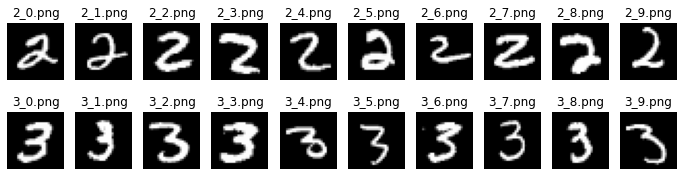

In [5]:
#  Load twos and threes
twos_im, twos_names = load(data_part2, digit='2')
threes_im, threes_names = load(data_part2, digit='3')

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Fourier descriptors - 4 digits (10 pts)

In [ ]:
# Add your implementation and discussion